In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('course_lead_scoring.csv')

# Data Preparation

In [3]:
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [4]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [6]:
dict_dtypes = df.dtypes.to_dict()
dict_dtypes

{'lead_source': dtype('O'),
 'industry': dtype('O'),
 'number_of_courses_viewed': dtype('int64'),
 'annual_income': dtype('float64'),
 'employment_status': dtype('O'),
 'location': dtype('O'),
 'interaction_count': dtype('int64'),
 'lead_score': dtype('float64'),
 'converted': dtype('int64')}

In [7]:
categorical = [k for k,v in dict_dtypes.items() if str(v) == 'object']
numerical = [k for k, v in dict_dtypes.items() if str(v) in(['int64', 'float64'])]
numerical.remove('converted')

In [8]:
for c in categorical:
    df[c] = df[c].fillna('NA')
for c in numerical:
    df[c] = df[c].fillna(0.0)

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

y_train = df_train.converted.values
y_full_train = df_full_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del(df_train['converted'])
del(df_val['converted'])
del(df_test['converted'])

# Question 1

In [12]:
from sklearn.metrics import roc_auc_score

for c in numerical:
    print(f'Feature {c} has ROC AUC: {roc_auc_score(y_train, df_train[c])}')

Feature number_of_courses_viewed has ROC AUC: 0.7635680590007088
Feature annual_income has ROC AUC: 0.5519578313253012
Feature interaction_count has ROC AUC: 0.738270176293409
Feature lead_score has ROC AUC: 0.6144993577250176


# Question 2

In [13]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc

In [14]:
train_dicts = df_train[categorical+numerical].to_dict(orient = 'records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [15]:
val_dicts = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [17]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [18]:
y_pred = model.predict_proba(X_val)[:, 1]


## Answer 2
My result is different from all the possible answers

In [19]:
roc_auc_score(y_val, y_pred)

0.8171316268814112

# Question 3

In [20]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [21]:
columns = ['thresholds' ,'tp', 'fp', 'fn', 'tn']
df_score = pd.DataFrame(scores, columns=columns)

In [22]:
df_score['precision'] = df_score.tp/(df_score.tp + df_score.fp)
df_score['recall'] = df_score.tp/(df_score.tp + df_score.fn)

## Answer 3 
My result is different from all the possible answers

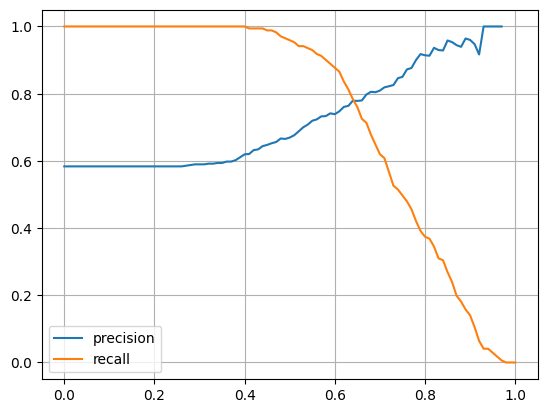

In [23]:
plt.plot(df_score.thresholds, df_score['precision'], label = 'precision')
plt.plot(df_score.thresholds, df_score['recall'], label = 'recall')
plt.legend()
plt.grid()

# Question 4 

In [24]:
df_score['f1'] = 2*(df_score['precision']*df_score['recall'])/(df_score['precision']+df_score['recall'])

In [25]:
df_score['f1'][50:60]

50    0.788462
51    0.791262
52    0.795062
53    0.802993
54    0.806045
55    0.811224
56    0.809278
57    0.812500
58    0.808399
59    0.808511
Name: f1, dtype: float64

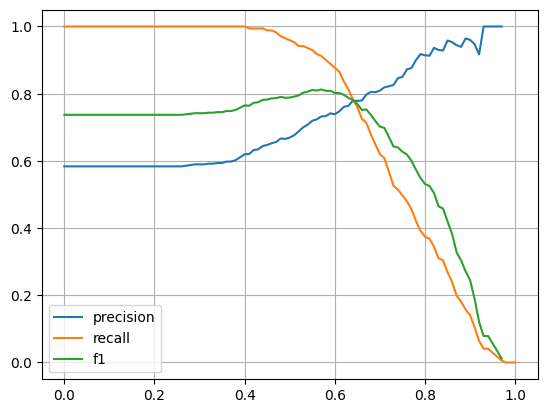

In [26]:
plt.plot(df_score.thresholds, df_score['precision'], label = 'precision')
plt.plot(df_score.thresholds, df_score['recall'], label = 'recall')
plt.plot(df_score.thresholds, df_score['f1'], label = 'f1')
plt.legend()
plt.grid()

# Question 5

In [27]:
from sklearn.model_selection import KFold

In [31]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [32]:
def train(df, y):
    dicts = df[categorical + numerical].to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [33]:
def predict(df, dv, model):
    dicts = df[categorical+numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred =  model.predict_proba(X)[:, 1]
    
    return y_pred

In [34]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.converted.values
    y_val = df_val.converted.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append(auc)

## Answer 5

In [36]:
np.mean(scores), np.var(scores)

(0.8221089148573075, 0.001282149801806368)

# Question 6

In [37]:
def train(df, y, C= 1.0):
    dicts = df[categorical + numerical].to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y)
    
    return dv, model

In [38]:
from tqdm.auto import tqdm

## Answer 6

In [40]:
n_splits = 5
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    scores = []
    
    for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=n_splits):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.converted.values
        y_val = df_val.converted.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print(f'{C} - {np.mean(scores)} - {np.std(scores)}') 
        
        

100%|██████████| 5/5 [00:00<00:00, 23.05it/s]


1e-06 - 0.5606368172975525 - 0.023973568035497696


100%|██████████| 5/5 [00:00<00:00,  9.35it/s]


0.001 - 0.8675514531651511 - 0.019080215702293297


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

1 - 0.9209041711116314 - 0.011018756799007634
